# Data Analysis
Analyze the dataset (`storage/corpus` and `qa_resources/questions.csv`) provided to you and the text associated embeddings, and report TWO significant findings you believe will impact the model or system's performance.

#### Import necessary libraries

In [1]:
import sys
sys.path.insert(1,'../')
from src.retrieval.search import Measure
from pipeline import Pipeline
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import Counter
import re
import os
import matplotlib.cm as cm

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt_tab to /Users/riley/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#### Precompute all embeddings for all corpus documents

In [2]:
# Initialize variables
sentences_per_chunk = 3
embedding_model_name="all-mpnet-base-v2"
qa_model_name="google-bert/bert-large-cased-whole-word-masking-finetuned-squad"
# Calculate embeddings for corpus documents
pipeline = Pipeline(
        measure=Measure.euclidean,
        embedding_model_name=embedding_model_name,
        qa_model_name=qa_model_name,
        sentences_per_chunk=sentences_per_chunk,
    )

/Users/riley/repos/karp-riley/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at google-bert/bert-large-cased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be e

Calculating embeddings...
Indexing embeddings...


#### Calculate principal components of all embeddings for all documents

In [67]:
# Read in embeddings from files for all 4 models, and find top 2 principal components using PCA
pca_obj = PCA(n_components=2)
pattern = f'../storage/embeddings/{embedding_model_name}/*.npy'
npy_files = glob(pattern)
embeddings = None
# Read all files in the model's embeddings folder
for i in range(len(npy_files)):
    filename = npy_files[i]
    with open(filename, 'rb') as f:
        embeddings = np.load(f).T if embeddings is None else np.vstack([embeddings, np.load(f).T])
# Find principal components
principal_components = pca_obj.fit_transform(embeddings)

# Print PCA explained variance
print(f'PCA component variances: {pca_obj.explained_variance_ratio_}')
print(f'Total variance explained by first 2 principal components: {np.sum(pca_obj.explained_variance_ratio_):.4f}')

PCA component variances: [0.05369635 0.05009344]
Total variance explained by first 2 principal components: 0.1038


## 1. Chunks per Document

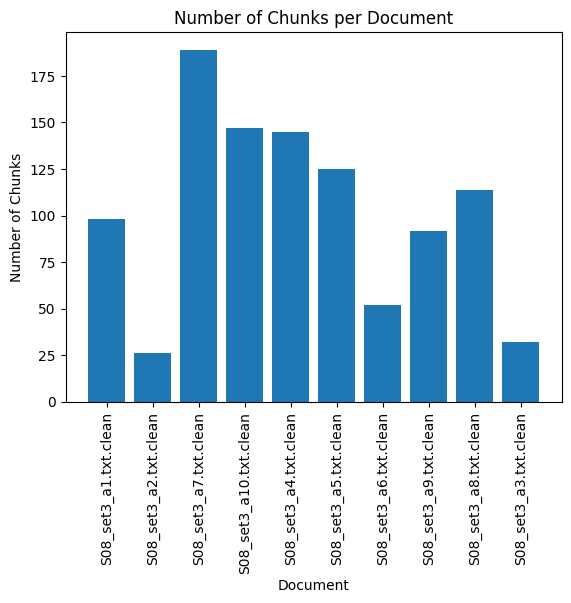

In [66]:
# Get document labels and unique document names
pattern = r'_\d+\.npy$'
labels = np.array([re.sub(pattern,'', os.path.basename(filename)) for filename in npy_files])
label_counts = Counter(labels)
doc_names = list(label_counts.keys())
counts = list(label_counts.values())

# Plot histogram
plt.bar(doc_names, counts)

# Format plot
plt.xlabel('Document')
plt.ylabel('Number of Chunks')
plt.title('Number of Chunks per Document')
plt.xticks(rotation=90)

plt.show()

## 2. Embedding Distribution by Document

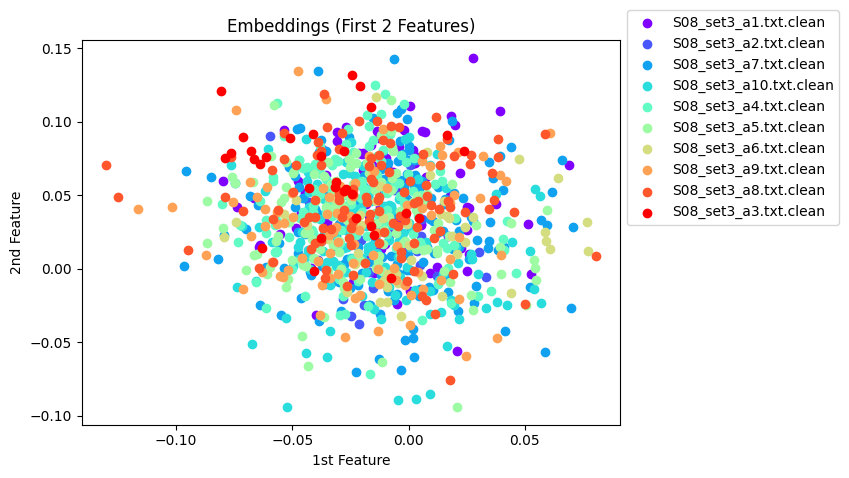

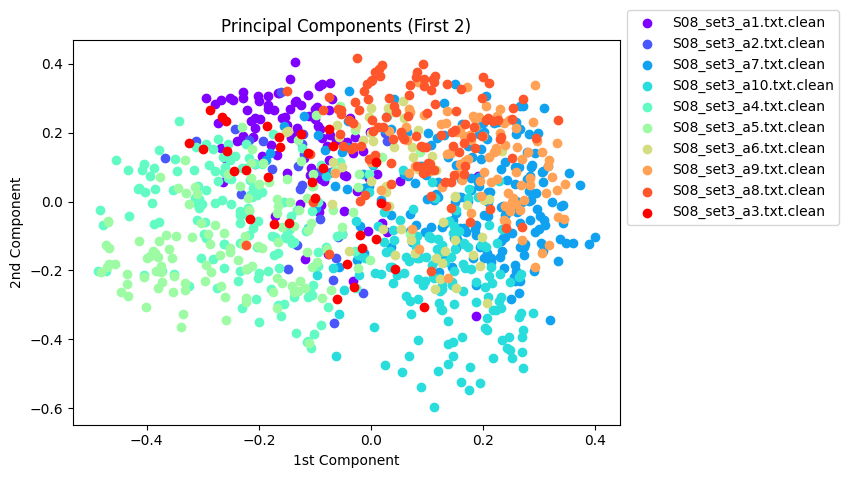

In [5]:
# Initialize colors list
colors = cm.rainbow(np.linspace(0, 1, len(doc_names)))

# Initialize plot axes
fig1, ax1 = plt.subplots() # Embeddings
fig2, ax2 = plt.subplots() # PCA

# Plot embeddings and PCA data
for j in range(len(doc_names)):
    doc = doc_names[j]
    docMask = labels == doc
    ax1.scatter(embeddings[docMask,0],embeddings[docMask,1],color=colors[j],label=doc)
    ax2.scatter(principal_components[docMask,0],principal_components[docMask,1],color=colors[j],label=doc)


# Format plots
ax1.set_title('Embeddings (First 2 Features)')
ax1.set_xlabel('1st Feature')
ax1.set_ylabel('2nd Feature')
line, label = ax1.get_legend_handles_labels()
fig1.legend(line, label,bbox_to_anchor=(1.33, 1))
fig1.tight_layout()

ax2.set_title('Principal Components (First 2)')
ax2.set_xlabel('1st Component')
ax2.set_ylabel('2nd Component')
line2, label2 = ax2.get_legend_handles_labels()
fig2.legend(line2, label2,bbox_to_anchor=(1.33, 1))
fig2.tight_layout()

plt.show()

# Additional Analysis
2 additional analyses beyond the requirement of 2 analyses.

## 3. Questions per Document

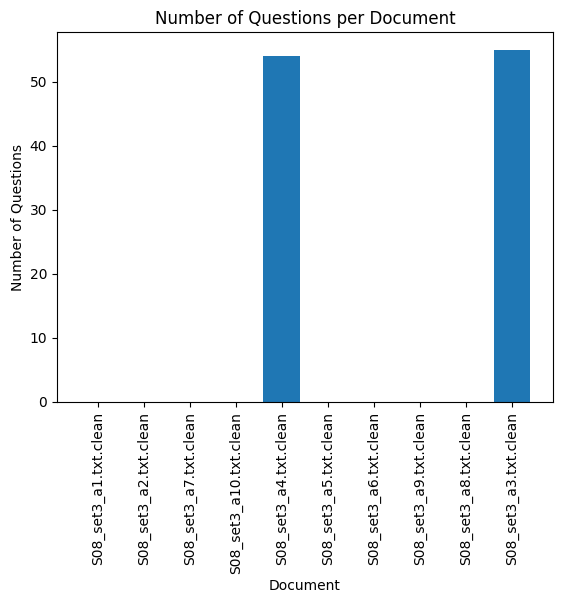

In [61]:
# Read in questions
questions = pd.read_csv("../qa_resources/questions.csv", delimiter="\t")

qCounts = {}
for doc in doc_names:
    articleFile = doc.removesuffix('.txt.clean')
    qCounts[doc] = np.sum(questions['ArticleFile'] == articleFile)

# Plot histogram
plt.bar(qCounts.keys(), qCounts.values())

# Format plot
plt.xlabel('Document')
plt.ylabel('Number of Questions')
plt.title('Number of Questions per Document')
plt.xticks(rotation=90)

plt.show()

## 4. Embedding Distributions of Questions and Answers

In [63]:
qEmbeddings = None
aEmbeddings = None

# Get embeddings for all quetions and answers
for idx, row in questions.iterrows():
    qText = row['Question']
    aText = '' if pd.isnull(row['Answer']) else row['Answer']
    qEmbedding = pipeline.get_embedding(qText)
    qEmbeddings = qEmbedding.T if qEmbeddings is None else np.vstack([qEmbeddings, qEmbedding.T])
    aEmbedding = pipeline.get_embedding(aText)
    aEmbeddings = aEmbedding.T if aEmbeddings is None else np.vstack([aEmbeddings, aEmbedding.T])

# Project question & answer embeddings along document principal components for plotting
qPCA = pca_obj.transform(qEmbeddings)
aPCA = pca_obj.transform(aEmbeddings)


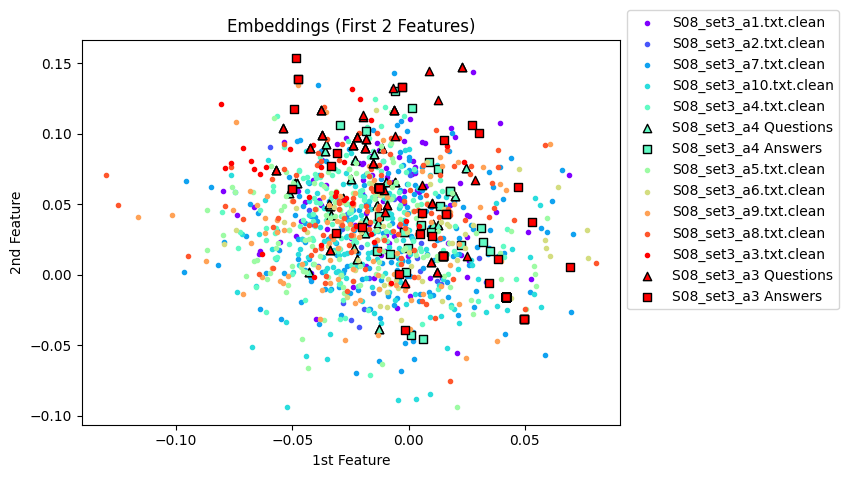

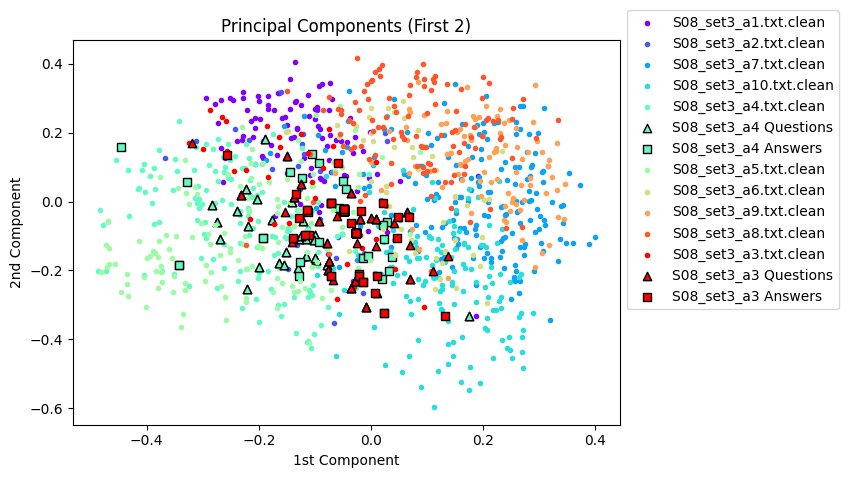

In [65]:
# Initialize plot axes
fig1, ax1 = plt.subplots() # Embeddings
fig2, ax2 = plt.subplots() # PCA

# Plot embeddings and PCA data
for j in range(len(doc_names)):
    doc = doc_names[j]
    docMask = labels == doc
    # Plot document embeddings & PCA
    ax1.scatter(embeddings[docMask,0],embeddings[docMask,1],marker='.',color=colors[j],label=doc)
    ax2.scatter(principal_components[docMask,0],principal_components[docMask,1],marker='.',color=colors[j],label=doc)

    articleFile = doc.removesuffix('.txt.clean')
    questionMask = questions['ArticleFile'] == articleFile
    if np.sum(questionMask) > 0:
        # Plot question & answer PCA
        ax2.scatter(qPCA[questionMask,0],qPCA[questionMask,1],color=colors[j],marker='^',edgecolor='black',linewidth=1,label=f'{articleFile} Questions')
        ax2.scatter(aPCA[questionMask,0],aPCA[questionMask,1],color=colors[j],marker='s',edgecolor='black',linewidth=1,label=f'{articleFile} Answers')
        # Plot question & answer embeddings
        ax1.scatter(qEmbeddings[questionMask,0],qEmbeddings[questionMask,1],color=colors[j],marker='^',edgecolor='black',linewidth=1,label=f'{articleFile} Questions')
        ax1.scatter(aEmbeddings[questionMask,0],aEmbeddings[questionMask,1],color=colors[j],marker='s',edgecolor='black',linewidth=1,label=f'{articleFile} Answers')

# Format plots
ax1.set_title('Embeddings (First 2 Features)')
ax1.set_xlabel('1st Feature')
ax1.set_ylabel('2nd Feature')
line, label = ax1.get_legend_handles_labels()
fig1.legend(line, label,bbox_to_anchor=(1.33, 1))
fig1.tight_layout()

ax2.set_title('Principal Components (First 2)')
ax2.set_xlabel('1st Component')
ax2.set_ylabel('2nd Component')
line2, label2 = ax2.get_legend_handles_labels()
fig2.legend(line2, label2,bbox_to_anchor=(1.33, 1))
fig2.tight_layout()

plt.show()
